# Torchvision Detection with Argoverse 1.1 with COCO format

In [1]:
import torch
import torchvision
from torchvision.models import get_model, get_model_weights, get_weight, list_models
print(torch.__version__) 
print(torchvision.__version__)

2.0.1
0.15.2


In [2]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name())

True
1
Tesla P100-PCIE-12GB


In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [4]:
import os
os.environ['TORCH_HOME'] = '/data/cmpe249-fa23/argo1COCO'
#DATAPATH='/data/cmpe249-fa23/torchvisiondata'

In [5]:
# https://github.com/pytorch/vision/blob/main/references/detection/transforms.py

from typing import Dict, List, Optional, Tuple, Union

import torch
import torchvision
from torch import nn, Tensor
from torchvision import ops
from torchvision.transforms import functional as F, InterpolationMode, transforms as T


class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class PILToTensor(nn.Module):
    def forward(
        self, image: Tensor, target: Optional[Dict[str, Tensor]] = None
    ) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]:
        image = F.pil_to_tensor(image)
        return image, target

class ToDtype(nn.Module):
    def __init__(self, dtype: torch.dtype, scale: bool = False) -> None:
        super().__init__()
        self.dtype = dtype
        self.scale = scale

    def forward(
        self, image: Tensor, target: Optional[Dict[str, Tensor]] = None
    ) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]:
        if not self.scale:
            return image.to(dtype=self.dtype), target
        image = F.convert_image_dtype(image, self.dtype)
        return image, target

class RandomHorizontalFlip(T.RandomHorizontalFlip):
    def forward(
        self, image: Tensor, target: Optional[Dict[str, Tensor]] = None
    ) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]:
        if torch.rand(1) < self.p:
            image = F.hflip(image)
            if target is not None:
                _, _, width = F.get_dimensions(image)
                target["boxes"][:, [0, 2]] = width - target["boxes"][:, [2, 0]]
                if "masks" in target:
                    target["masks"] = target["masks"].flip(-1)
                if "keypoints" in target:
                    keypoints = target["keypoints"]
                    keypoints = _flip_coco_person_keypoints(keypoints, width)
                    target["keypoints"] = keypoints
        return image, target

In [8]:
import DeepDataMiningLearning.detection.transforms as T
def get_transformsimple():
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ToDtype(torch.float, scale=True))
    # if train:
    #     transforms.append(RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [9]:
from detection.dataset_argo1coco import Argo1COCODataset

data_path='/data/cmpe249-fa23/Argoverse/Argoverse-1.1/images/'
ann_file='/data/cmpe249-fa23/argo1COCO/argo1_all.json'
is_train = True
myargo1coco = Argo1COCODataset(root=data_path,  
                          annotation=ann_file,
                            train = is_train,
                          transform=get_transformsimple())

loading annotations into memory...
Done (t=11.39s)
creating index...
index created!


In [10]:
myargo1coco.numclass

8

In [9]:
print("Dataset len",len(myargo1coco))

Dataset len 39372


In [10]:
img, target = myargo1coco[0]
imgdata=img.permute(1, 2, 0) #CHW -> HWC
imgdata.shape

torch.Size([1200, 1920, 3])

In [11]:
dataset_train = myargo1coco

In [12]:
ann_file_val='/data/cmpe249-fa23/argo1COCO/argo1_val_all.json'
is_train = False
mode="instances"
dataset_val = Argo1COCODataset(root=data_path,
        annotation = ann_file_val,
        train = is_train,
        transform=get_transformsimple()
    )

loading annotations into memory...
Done (t=3.27s)
creating index...
index created!


In [13]:
train_sampler = torch.utils.data.RandomSampler(dataset_train)
test_sampler = torch.utils.data.SequentialSampler(dataset_val)

In [14]:
BATCH_SIZE=16
train_batch_sampler = torch.utils.data.BatchSampler(train_sampler, BATCH_SIZE, drop_last=True)

def collate_fn(batch):
    return tuple(zip(*batch))
train_collate_fn = collate_fn

In [15]:
WORKERS = 4
data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_sampler=train_batch_sampler, num_workers=WORKERS, collate_fn=train_collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_val, batch_size=1, sampler=test_sampler, num_workers=WORKERS, collate_fn=collate_fn
)

In [11]:
# Firstly, download pre-trained model
# reference: https://pytorch.org/vision/stable/models.html

all_models = list_models()
classification_models = list_models(module=torchvision.models)

# Initialize models
#m1 = get_model("mobilenet_v3_large", weights=None)
m1 = get_model('fasterrcnn_resnet50_fpn_v2', weights="DEFAULT")


In [4]:
m2 = get_model('resnet152', weights = "DEFAULT")

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /data/cmpe249-fa23/argo1COCO/hub/checkpoints/resnet152-f82ba261.pth
100%|█████████████████████████████████████████| 230M/230M [00:02<00:00, 117MB/s]


In [8]:
import os  
import torch 
from DeepDataMiningLearning.detection.models import CustomRCNN # I assume you named your model as Model, change it accordingly

backbonename = "resnet152"
model2 = CustomRCNN(backbone_modulename=backbonename,
                    trainable_layers=0,
                    num_classes=8,
                    out_channels=256,min_size=800,max_size=1333)  # Then in here instantiate your model
model_path = '/data/cmpe249-fa23/argo1COCO/trainoutput/cusrcnn_model_0.pth'
checkpoint = torch.load(model_path)
model2.load_state_dict(checkpoint['model'])  # Then load your model's weights.
device = "cuda" if torch.cuda.is_available() else "cpu"
model2 = model2.to(device).eval()

In [9]:
model2

CustomRCNN(
  (detcttransform): DetectionTransform()
  (backbone): MyBackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, a

In [18]:
print("Creating model")
from torchvision.models import get_model, get_model_weights, get_weight, list_models
def get_torchvision_detection_models(modelname, box_score_thresh=0.9):
    weights_enum = get_model_weights(modelname) #<enum 'FasterRCNN_MobileNet_V3_Large_320_FPN_Weights'>
    weights = weights_enum.DEFAULT #get the default weights
    preprocess = weights.transforms()
    classes = weights.meta["categories"]
    pretrained_model=get_model(modelname, box_score_thresh=0.9, weights="DEFAULT")
    return pretrained_model, preprocess, weights, classes

modelname='fasterrcnn_resnet50_fpn_v2'
pretrained_model, preprocess, weights, classes = get_torchvision_detection_models(modelname)

Creating model


In [16]:
pretrained_model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [20]:
parameters = [p for p in pretrained_model.parameters() if p.requires_grad]

In [21]:
optimizer = torch.optim.AdamW(parameters, lr=0.02, weight_decay=1e-4)

In [6]:
import datetime
import os
import time
import math
import sys
import torch
import torch.utils.data
import torchvision
import torchvision.models.detection

from DeepDataMiningLearning.detection import utils
from DeepDataMiningLearning.detection.trainutils import create_aspect_ratio_groups, GroupedBatchSampler

from DeepDataMiningLearning.detection.dataset import get_dataset #get_cocodataset, get_kittidataset, get_transform
from DeepDataMiningLearning.detection.models import create_detectionmodel #get_torchvision_detection_models, modify_fasterrcnnheader
from DeepDataMiningLearning.detection.myevaluator import simplemodelevaluate, modelevaluate


/home/015957045/anaconda3/envs/mycondapy310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
from DeepDataMiningLearning.detection import utils
from DeepDataMiningLearning.detection.myevaluator import get_coco_api_from_dataset, CocoEvaluator

def modelevaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    #torch.set_num_threads(1)
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = "Test:"

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = utils._get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = list(img.to(device) for img in images)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(images)

        outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"]: output for target, output in zip(targets, outputs)}
        #print("res:", res)
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator

convert to coco api:


  0%|                                         | 1/15055 [00:00<30:30,  8.23it/s]

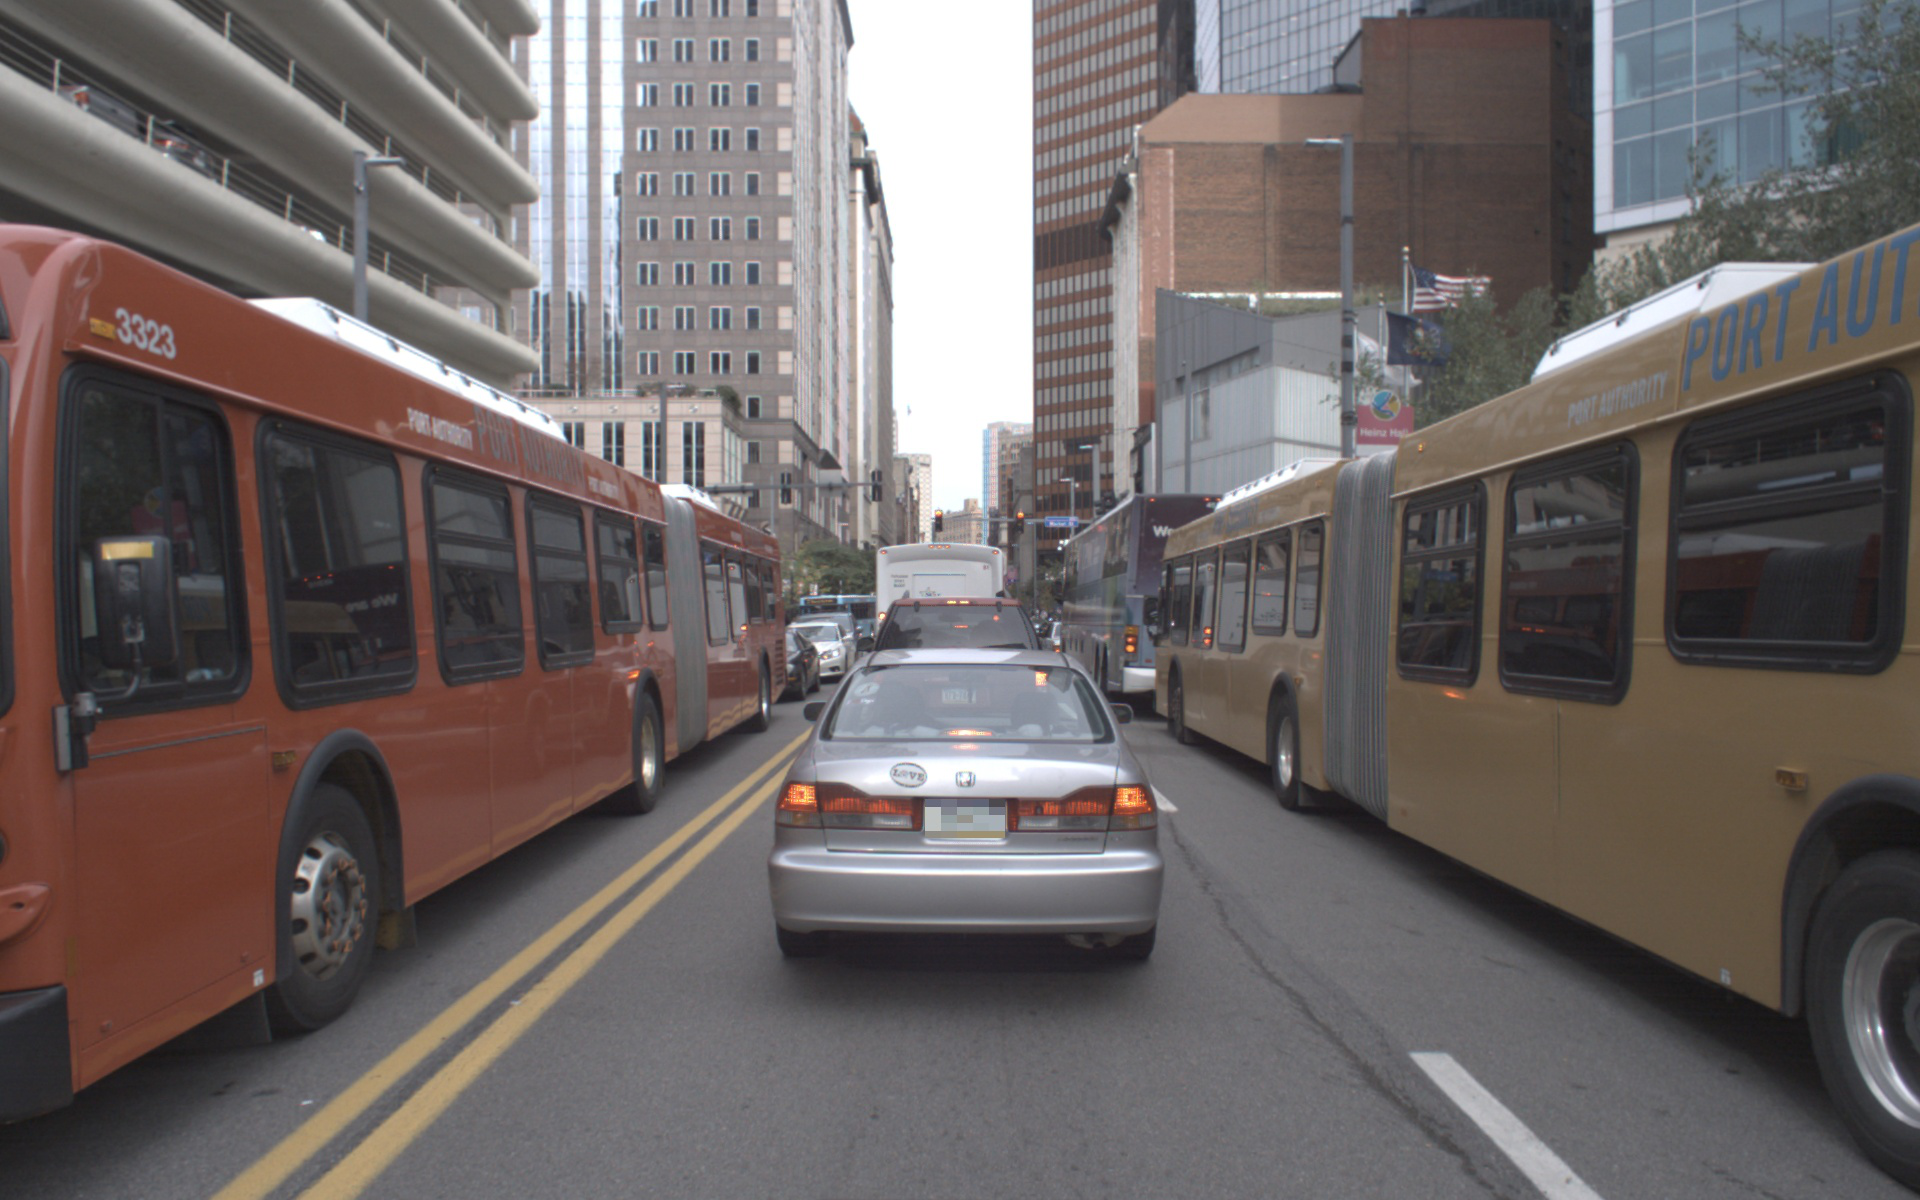

  0%|                                       | 2/15055 [00:01<3:16:39,  1.28it/s]

image info: val/33737504-3373-3373-3373-633738571776/ring_front_center/ring_front_center_315968425169569624.jpg


100%|████████████████████████████████████▉| 15054/15055 [16:04<00:00, 20.55it/s]

creating index...


100%|█████████████████████████████████████| 15055/15055 [16:04<00:00, 15.61it/s]

index created!


Test:  [    0/15055]  eta: 22:06:46  model_time: 4.8218 (4.8218)  evaluator_time: 0.0120 (0.0120)  time: 5.2877  data: 0.3763  max mem: 2606
image info: val/33737504-3373-3373-3373-633738571776/ring_front_center/ring_front_center_315968425169569624.jpg
Test:  [  100/15055]  eta: 1:06:02  model_time: 0.1289 (0.1766)  evaluator_time: 0.0105 (0.0093)  time: 0.1917  data: 0.0107  max mem: 4240
Test:  [  200/15055]  eta: 0:54:21  model_time: 0.1227 (0.1513)  evaluator_time: 0.0047 (0.0079)  time: 0.1682  data: 0.0086  max mem: 4240
Test:  [  300/15055]  eta: 0:49:40  model_time: 0.1234 (0.1418)  evaluator_time: 0.0045 (0.0068)  time: 0.1686  data: 0.0085  max mem: 4240
Test:  [  400/15055]  eta: 0:47:10  model_time: 0.1225 (0.1370)  evaluator_time: 0.0047 (0.0062)  time: 0.1668  data: 0.0079  max mem: 4240
Test:  [  500/15055]  eta: 0:45:36  model_time: 0.1225 (0.1341)  evaluator_time: 0.0044 (0.0059)  time: 0.1669  data: 0.0082  max mem: 4240
Test:  [  600/15055]  eta: 0:44:26  model_time:

In [31]:
modelevaluate(pretrained_model, data_loader_test, device=device)